In [17]:
import os
import json
import numpy as np
import mne
import warnings
from sklearn.model_selection import KFold
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [18]:
# Ignore RuntimeWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Enable CUDA
mne.utils.set_config('MNE_USE_CUDA', 'true')
mne.cuda.init_cuda(verbose=False)  # Set to True for debugging

# Load Data

In [19]:
# Load subject labels
with open("model-data/Labels_epochs.json", "r") as f:
    subject_labels = json.load(f)

def load_data(directory):
    """
    Loads and returns augmented EEG data (X) and corresponding labels (y) from the specified directory.
    """
    X, y = [], []
    for file in os.listdir(directory):
        if file.endswith(".npy"):
            # Load the features (EEG data)
            X_data = np.load(os.path.join(directory, file))
            # Load corresponding label (subject ID matches file naming convention)
            subject_id = file.split("_")[0]
            label = subject_labels.get(subject_id, None)
            if label is not None:
                X.append(X_data)
                y.append(label)

    return np.array(X), np.array(y)

def preprocess_eeg_3d(eeg_data_3d):
    """
    Preprocess 3D EEG data for Random Forest input by extracting features from each window
    and computing the average features across all windows.
    
    Args:
        eeg_data_3d (numpy.ndarray): 3D EEG data with shape (windows, channels, samples)
                                     or (windows, samples, channels)
    
    Returns:
        numpy.ndarray: Averaged features across all windows
    """
    # Get the dimensions
    A, B, C = eeg_data_3d.shape
    
    # Initialize array to store features for each window
    all_window_features = []
    
    # Process each window
    for window_idx in range(A):
        # Extract the 2D data for this window
        window_data = eeg_data_3d[window_idx, :, :]
        
        # If data is (samples, channels), transpose it
        if B > C:
            window_data = window_data.T
            
        num_channels = window_data.shape[0]
        
        # Feature extraction for this window
        window_features = []
        
        # Time domain and frequency domain features
        for channel in range(num_channels):
            channel_data = window_data[channel, :]
            
            # Time domain features
            window_features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.max(channel_data),
                np.min(channel_data),
                np.percentile(channel_data, 75) - np.percentile(channel_data, 25)
            ])
            
            # Frequency domain features
            fft_data = np.abs(np.fft.rfft(channel_data))
            # Normalized frequency band powers
            total_power = np.sum(fft_data)
            if total_power > 0:  # Avoid division by zero
                window_features.extend([
                    np.sum(fft_data[:5]) / total_power,  # Delta
                    np.sum(fft_data[5:12]) / total_power,  # Theta
                    np.sum(fft_data[12:30]) / total_power,  # Alpha
                    np.sum(fft_data[30:80]) / total_power,  # Beta
                    np.sum(fft_data[80:]) / total_power  # Gamma
                ])
            else:
                window_features.extend([0, 0, 0, 0, 0])  # Zero power case
                
        all_window_features.append(window_features)
    
    # Convert to numpy array for easier computation
    all_window_features = np.array(all_window_features)
    
    # Compute average features across all windows
    avg_features = np.mean(all_window_features, axis=0)
    
    return avg_features

def preprocess_dataset(data_4d):
    """
    Process 4D EEG data by extracting features for each subject.
    
    Args:
        data_4d (numpy.ndarray): 4D EEG data with shape (subjects, windows, channels, samples)
                                or (subjects, windows, samples, channels)
    
    Returns:
        numpy.ndarray: 2D array where each row represents a subject's features
    """
    num_subjects = data_4d.shape[0]
    processed_features = []
    
    # Process each subject separately
    for subject_idx in range(num_subjects):
        # Extract the 3D data for this subject
        subject_data = data_4d[subject_idx]
        
        # Process this subject's 3D data using our window-processing function
        subject_features = preprocess_eeg_3d(subject_data)
        
        # Add to our collection
        processed_features.append(subject_features)
    
    # Convert to numpy array - shape will be (num_subjects, num_features)
    return np.array(processed_features)


# Preprocessing

In [20]:
"""
Normalize a 2D numpy array using Z-score normalization (standardization).

Parameters:
-----------
arr : numpy.ndarray
    Input 2D array to be normalized
axis : None or int, optional
    Axis along which to normalize. 
    None (default) to normalize the entire array
    0 to normalize along columns (features)
    1 to normalize along rows (samples)

Returns:
--------
numpy.ndarray
    Z-score normalized array with the same shape as input

Raises:
-------
ValueError
    If input is not a 2D array
"""

def zscore_normalize_2d_array(arr, axis=None):
    # Check if input is a 2D array
    if arr.ndim != 2:
        raise ValueError("Input must be a 2D array, got shape: {}".format(arr.shape))
    
    # Make a copy to avoid modifying the original array
    result = arr.copy()
    
    # Calculate mean and standard deviation
    mean = np.mean(result, axis=axis, keepdims=True)
    std = np.std(result, axis=axis, keepdims=True)
    
    # Avoid division by zero by setting zero std values to 1
    std[std == 0] = 1
    
    # Perform z-score normalization: (x - mean) / std
    normalized = (result - mean) / std
    
    return normalized

# Models

In [21]:
class EEGRF:
    """
    Random Forest model for EEG classification with hyperparameter optimization.
    """

    def __init__(self, n_estimators=100, max_depth=None, class_weight=None):
        """
        Initialize the Random Forest model.

        Args:
            n_estimators (int): Number of trees in the forest
            max_depth (int or None): The maximum depth of the trees
            class_weight (dict or 'balanced'): Weights associated with classes in the form {class_label: weight}
        """
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            class_weight=class_weight,
            random_state=42
        )

    def train(self, X_train, y_train):
        """
        Train the Random Forest model.

        Args:
            X_train (numpy.ndarray): Training features
            y_train (numpy.ndarray): Training labels

        Returns:
            EEGRF: Self for method chaining
        """
        print("Training Random Forest model...")
        self.model.fit(X_train, y_train)

        train_pred = self.model.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        print(f"Training accuracy: {train_acc:.4f}")

        return self

    def predict(self, X):
        """
        Make predictions with the trained model.

        Args:
            X (numpy.ndarray): Features

        Returns:
            numpy.ndarray: Predictions
        """
        return self.model.predict(X)

In [22]:

class EEGSVM:
    """
    Support Vector Machine model for EEG classification with hyperparameter optimization.
    """

    def __init__(self, C=1.0, kernel='rbf', class_weight=None):
        """
        Initialize the SVM model.

        Args:
            C (float): Regularization parameter
            kernel (str): Kernel type to be used in the algorithm
            class_weight (dict or 'balanced'): Weights associated with classes
        """
        # Initialize the SVC with given hyperparameters
        self.model = SVC(
            C=C,
            kernel=kernel,
            class_weight=class_weight,
            probability=True,
            random_state=42
        )

    def train(self, X_train, y_train):
        """
        Train the SVM model.

        Args:
            X_train (numpy.ndarray): Training features
            y_train (numpy.ndarray): Training labels

        Returns:
            EEGSVM: Self for method chaining
        """
        print("Training SVM model...")
        self.model.fit(X_train, y_train)

        train_pred = self.model.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        print(f"Training accuracy: {train_acc:.4f}")

        return self

    def predict(self, X):
        """
        Make predictions with the trained model.

        Args:
            X (numpy.ndarray): Features

        Returns:
            numpy.ndarray: Predictions
        """
        return self.model.predict(X)

In [23]:
class EEGGradientBoost:
    """
    Gradient Boosting model for EEG classification with hyperparameter optimization.
    """

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0):
        """
        Initialize the Gradient Boosting model.

        Args:
            n_estimators (int): Number of boosting stages
            learning_rate (float): Learning rate shrinks the contribution of each tree
            max_depth (int): Maximum depth of the individual regression estimators
            subsample (float): The fraction of samples to be used for fitting the individual base learners
        """
        # Initialize the GradientBoostingClassifier with given hyperparameters
        self.model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            random_state=42
        )

    def train(self, X_train, y_train):
        """
        Train the Gradient Boosting model.

        Args:
            X_train (numpy.ndarray): Training features
            y_train (numpy.ndarray): Training labels

        Returns:
            EEGGradientBoost: Self for method chaining
        """
        print("Training Gradient Boosting model...")
        self.model.fit(X_train, y_train)

        train_pred = self.model.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        print(f"Training accuracy: {train_acc:.4f}")

        return self

    def predict(self, X):
        """
        Make predictions with the trained model.

        Args:
            X (numpy.ndarray): Features

        Returns:
            numpy.ndarray: Predictions
        """
        return self.model.predict(X)

# Evaluation

In [27]:
def cross_validation(model, X_test, y_test, n_splits=5):
    """
    Evaluate a trained model using k-fold cross-validation.
    
    Args:
        model: Trained model with a predict function
        X_test (numpy.ndarray): Test features
        y_test (numpy.ndarray): Test labels
        n_splits (int): Number of folds
    
    Returns:
        dict: Dictionary with evaluation metrics
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Initialize metrics
    all_confusion = []
    all_accuracy = []
    all_precision = []
    all_recall = []
    all_f1 = []
    
    # If y is one-hot encoded, convert to class labels
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)
    
    # Get number of classes
    n_classes = len(np.unique(y_test))
    
    fold_idx = 1
    for train_index, test_index in kf.split(X_test):
        X_fold = X_test[test_index]
        y_fold = y_test[test_index]
        
        # Make predictions
        y_pred = model.predict(X_fold)
        
        # Calculate metrics
        cm = confusion_matrix(y_fold, y_pred)
        acc = accuracy_score(y_fold, y_pred)
        
        # Handle binary vs multi-class
        if n_classes <= 2:
            prec = precision_score(y_fold, y_pred)
            rec = recall_score(y_fold, y_pred)
            f1 = f1_score(y_fold, y_pred)
        else:
            prec = precision_score(y_fold, y_pred, average='weighted')
            rec = recall_score(y_fold, y_pred, average='weighted')
            f1 = f1_score(y_fold, y_pred, average='weighted')
        
        # Store metrics
        all_confusion.append(cm)
        all_accuracy.append(acc)
        all_precision.append(prec)
        all_recall.append(rec)
        all_f1.append(f1)
        
        print(f"Fold {fold_idx} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, "
              f"Recall: {rec:.4f}, F1: {f1:.4f}")
        fold_idx += 1
    
    # Calculate average metrics
    avg_cm = np.mean(all_confusion, axis=0)
    avg_acc = np.mean(all_accuracy)
    avg_prec = np.mean(all_precision)
    avg_rec = np.mean(all_recall)
    avg_f1 = np.mean(all_f1)
    
    # Print average metrics
    print("\nAverage Metrics:")
    print(f"Accuracy: {avg_acc:.4f}")
    print(f"Precision: {avg_prec:.4f}")
    print(f"Recall: {avg_rec:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")
    
    # Plot average confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Average Confusion Matrix')
    plt.show()
    
    # Return results
    return {
        'confusion_matrix': avg_cm,
        'accuracy': avg_acc,
        'precision': avg_prec,
        'recall': avg_rec,
        'f1': avg_f1
    }

In [28]:
def evaluate_model(model, X_test, y_test):
    # Get model predictions
    y_pred = model.predict(X_test)
    
    # Convert probabilities to class labels if needed
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)
    
    # Calculate evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    
    # For multi-class problems, specify average method
    # Common options: 'micro', 'macro', 'weighted'
    average_method = 'weighted'
    
    prec = precision_score(y_test, y_pred, average=average_method, zero_division=0)
    rec = recall_score(y_test, y_pred, average=average_method, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=average_method, zero_division=0)
    
    # Print the results
    print("\n----- Model Evaluation Results -----")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()
    
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# Running

In [25]:
X_train, y_train = load_data("model-data/epochs-numpy-corrected/train")
X_test, y_test = load_data("model-data/epochs-numpy-corrected/test")

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# Apply the processing to both train and test datasets
X_train = preprocess_dataset(X_train)
X_test = preprocess_dataset(X_test)

# Print the shapes to confirm
print(f"Processed train_data shape: {X_train.shape}")
print(f"Processed test_data shape: {X_test.shape}")

(240, 476, 19, 190) (104, 476, 19, 190)
(240,) (104,)
Processed train_data shape: (240, 190)
Processed test_data shape: (104, 190)


In [26]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

Training Random Forest model...
Training accuracy: 1.0000
Fold 1 - Accuracy: 0.7143, Precision: 0.7347, Recall: 0.7143, F1: 0.7213
Fold 2 - Accuracy: 0.7143, Precision: 0.7687, Recall: 0.7143, F1: 0.7222
Fold 3 - Accuracy: 0.8571, Precision: 0.9048, Recall: 0.8571, F1: 0.8621
Fold 4 - Accuracy: 0.6667, Precision: 0.9000, Recall: 0.6667, F1: 0.7070
Fold 5 - Accuracy: 0.8000, Precision: 0.8562, Recall: 0.8000, F1: 0.7969

Average Metrics:
Accuracy: 0.7505
Precision: 0.8329
Recall: 0.7505
F1 Score: 0.7619


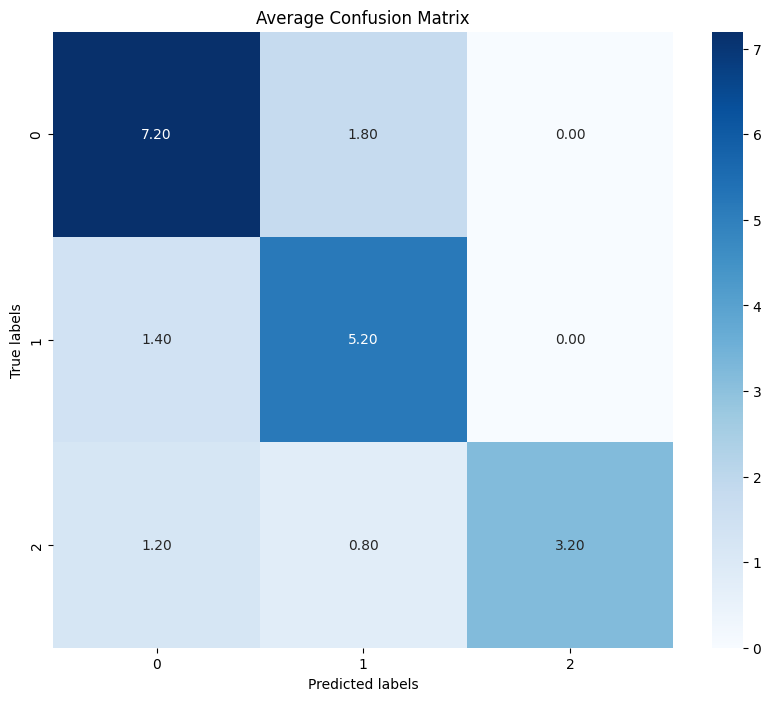


Final Evaluation Results:
Average Accuracy: 0.7505
Average Precision: 0.8329
Average Recall: 0.7505
Average F1 Score: 0.7619

----- Model Evaluation Results -----
Accuracy:  0.7500
Precision: 0.7794
Recall:    0.7500
F1 Score:  0.7511


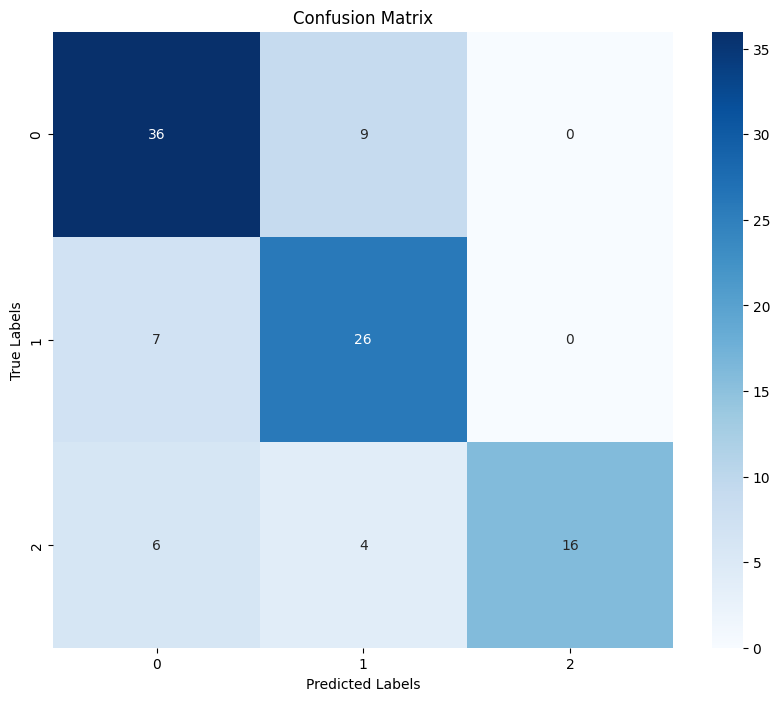

{'accuracy': 0.75,
 'precision': 0.7794348508634223,
 'recall': 0.75,
 'f1_score': 0.7510667523965396,
 'confusion_matrix': array([[36,  9,  0],
        [ 7, 26,  0],
        [ 6,  4, 16]])}

In [31]:
# Initialize and train the model
rf_model = EEGRF(n_estimators=100, max_depth=None, class_weight='balanced')
rf_model.train(X_train, y_train)

results = cross_validation(rf_model, X_test, y_test, n_splits=5)
print(f"\nFinal Evaluation Results:")
print(f"Average Accuracy: {results['accuracy']:.4f}")
print(f"Average Precision: {results['precision']:.4f}")
print(f"Average Recall: {results['recall']:.4f}")
print(f"Average F1 Score: {results['f1']:.4f}")

evaluate_model(rf_model, X_test, y_test)

Training SVM model...
Training accuracy: 0.3000
Fold 1 - Accuracy: 0.2857, Precision: 0.1464, Recall: 0.2857, F1: 0.1818
Fold 2 - Accuracy: 0.0952, Precision: 0.0254, Recall: 0.0952, F1: 0.0401
Fold 3 - Accuracy: 0.1429, Precision: 0.0690, Recall: 0.1429, F1: 0.0731
Fold 4 - Accuracy: 0.3810, Precision: 0.3743, Recall: 0.3810, F1: 0.3672
Fold 5 - Accuracy: 0.2000, Precision: 0.0933, Recall: 0.2000, F1: 0.1273

Average Metrics:
Accuracy: 0.2210
Precision: 0.1417
Recall: 0.2210
F1 Score: 0.1579


C:\Users\27298\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\27298\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\27298\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

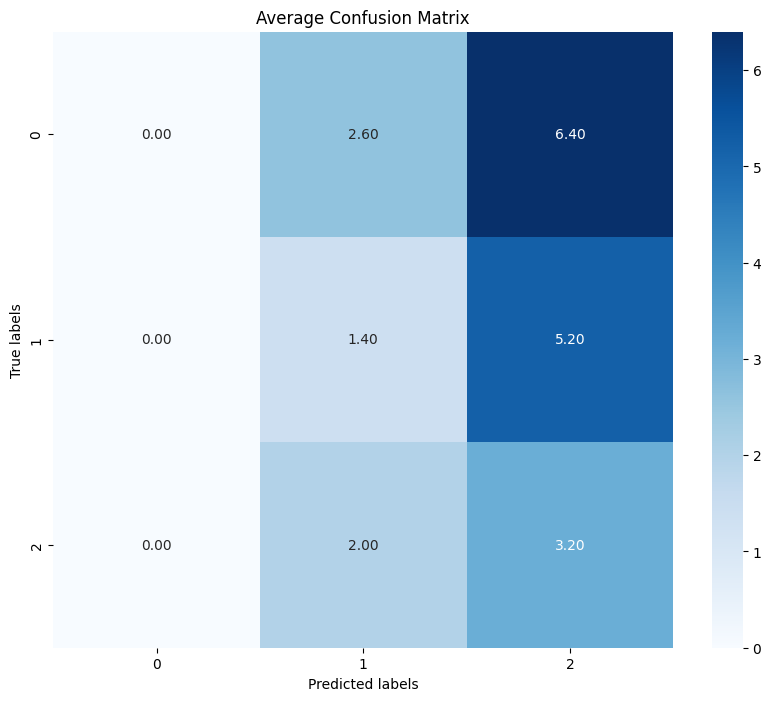


Final Evaluation Results:
Average Accuracy: 0.2210
Average Precision: 0.1417
Average Recall: 0.2210
Average F1 Score: 0.1579

----- Model Evaluation Results -----
Accuracy:  0.2212
Precision: 0.1281
Recall:    0.2212
F1 Score:  0.1505


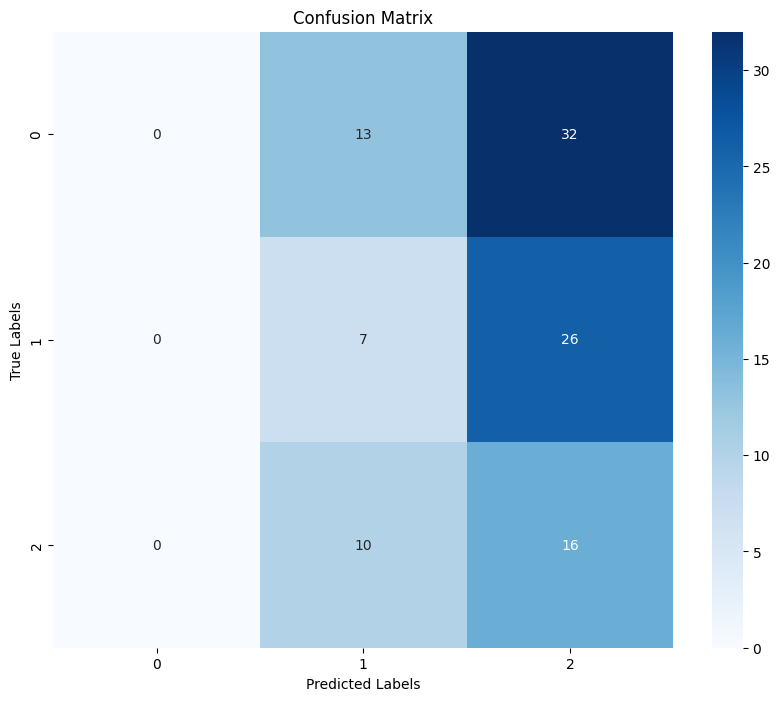

{'accuracy': 0.22115384615384615,
 'precision': 0.1280925155925156,
 'recall': 0.22115384615384615,
 'f1_score': 0.1505128205128205,
 'confusion_matrix': array([[ 0, 13, 32],
        [ 0,  7, 26],
        [ 0, 10, 16]])}

In [33]:
svm_model = EEGSVM(C=1.0, kernel='rbf', class_weight='balanced')
svm_model.train(X_train, y_train)

results = cross_validation(svm_model, X_test, y_test, n_splits=5)
print(f"\nFinal Evaluation Results:")
print(f"Average Accuracy: {results['accuracy']:.4f}")
print(f"Average Precision: {results['precision']:.4f}")
print(f"Average Recall: {results['recall']:.4f}")
print(f"Average F1 Score: {results['f1']:.4f}")

evaluate_model(svm_model, X_test, y_test)

Training Gradient Boosting model...
Training accuracy: 1.0000
Fold 1 - Accuracy: 0.8095, Precision: 0.8316, Recall: 0.8095, F1: 0.8112
Fold 2 - Accuracy: 0.6667, Precision: 0.7211, Recall: 0.6667, F1: 0.6746
Fold 3 - Accuracy: 0.9048, Precision: 0.9286, Recall: 0.9048, F1: 0.9076
Fold 4 - Accuracy: 0.6667, Precision: 0.8466, Recall: 0.6667, F1: 0.6905
Fold 5 - Accuracy: 0.8000, Precision: 0.8397, Recall: 0.8000, F1: 0.7923

Average Metrics:
Accuracy: 0.7695
Precision: 0.8335
Recall: 0.7695
F1 Score: 0.7752


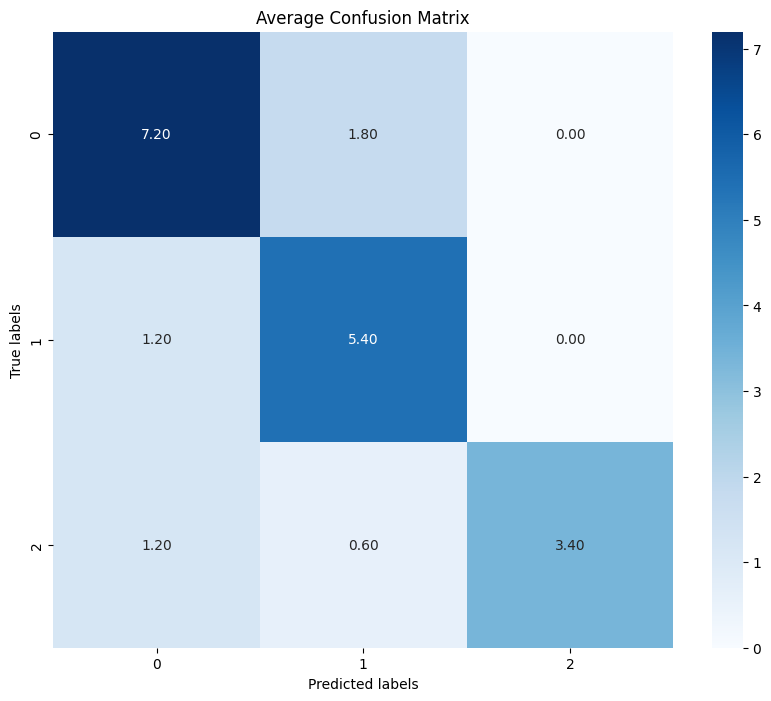


Final Evaluation Results:
Average Accuracy: 0.7695
Average Precision: 0.8335
Average Recall: 0.7695
Average F1 Score: 0.7752

----- Model Evaluation Results -----
Accuracy:  0.7692
Precision: 0.7942
Recall:    0.7692
F1 Score:  0.7706


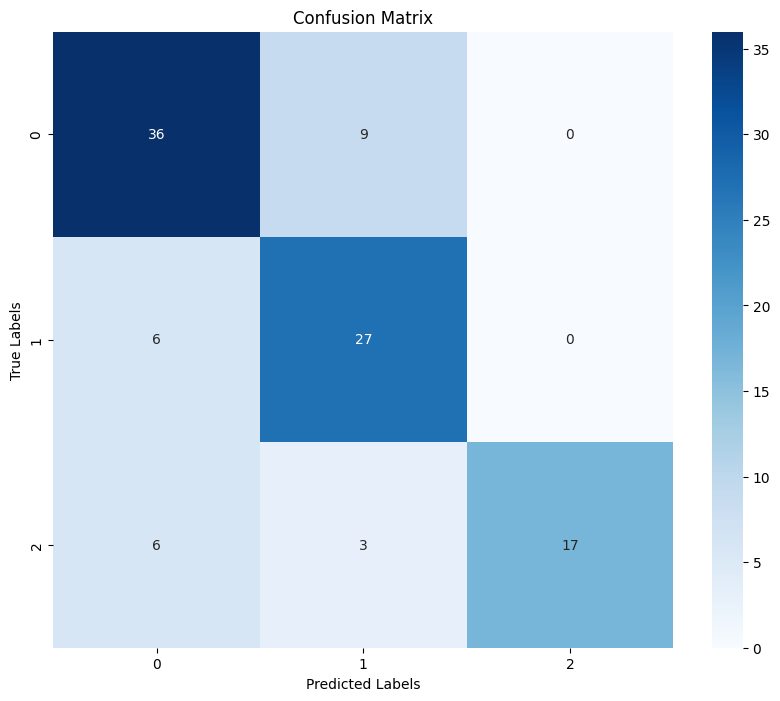

{'accuracy': 0.7692307692307693,
 'precision': 0.7941937869822484,
 'recall': 0.7692307692307693,
 'f1_score': 0.7706427808875295,
 'confusion_matrix': array([[36,  9,  0],
        [ 6, 27,  0],
        [ 6,  3, 17]])}

In [34]:
gb_model = EEGGradientBoost(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0
)
gb_model.train(X_train, y_train)

results = cross_validation(gb_model, X_test, y_test, n_splits=5)
print(f"\nFinal Evaluation Results:")
print(f"Average Accuracy: {results['accuracy']:.4f}")
print(f"Average Precision: {results['precision']:.4f}")
print(f"Average Recall: {results['recall']:.4f}")
print(f"Average F1 Score: {results['f1']:.4f}")

evaluate_model(gb_model, X_test, y_test)